In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.models import *
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [2]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [3]:


# Load the data
df = pd.read_csv(r"C:\Users\bakiD\OneDrive\Belgeler\Yeni klasör (7)\labels.csv")




In [4]:
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [5]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


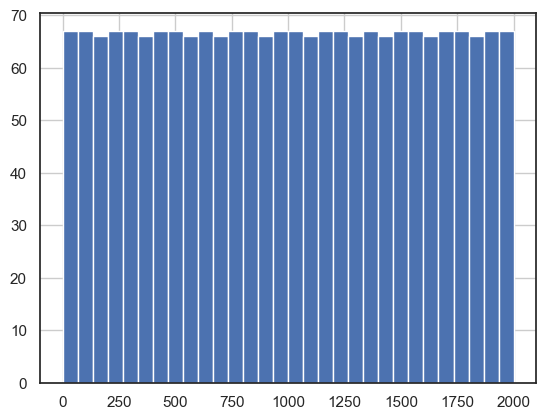

In [6]:
# 'adet' sütununu kullanarak histogram çizin
# 'id' sütununu kullanarak histogram çizin
df['id'].hist(bins=30);



In [7]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    # rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    # zoom_range=0.2,  # Randomly zoom image
    # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

In [30]:
# Setup some constants
size = 640
batch_size = 64

In [31]:
# Flow_from_dataframe kullanarak veri akışı oluşturuyoruz
flow_params = dict(
    dataframe=df,
    directory=r"C:\Users\bakiD\OneDrive\Belgeler\Yeni klasör (7)\frames",
    x_col="image_name",  # Girişlerimizi temsil eden sütun
    y_col="id",        # Etiketlerimizi temsil eden sütun
    target_size=(size, 480),  # Hedef görüntü boyutları
    color_mode='rgb',  # Renkli görüntüler
    class_mode="raw",  # Etiketleri kullanma modu
    batch_size=batch_size,
    shuffle=True,  # Veri karıştırma
    seed=0,
)
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params
)

valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)



Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

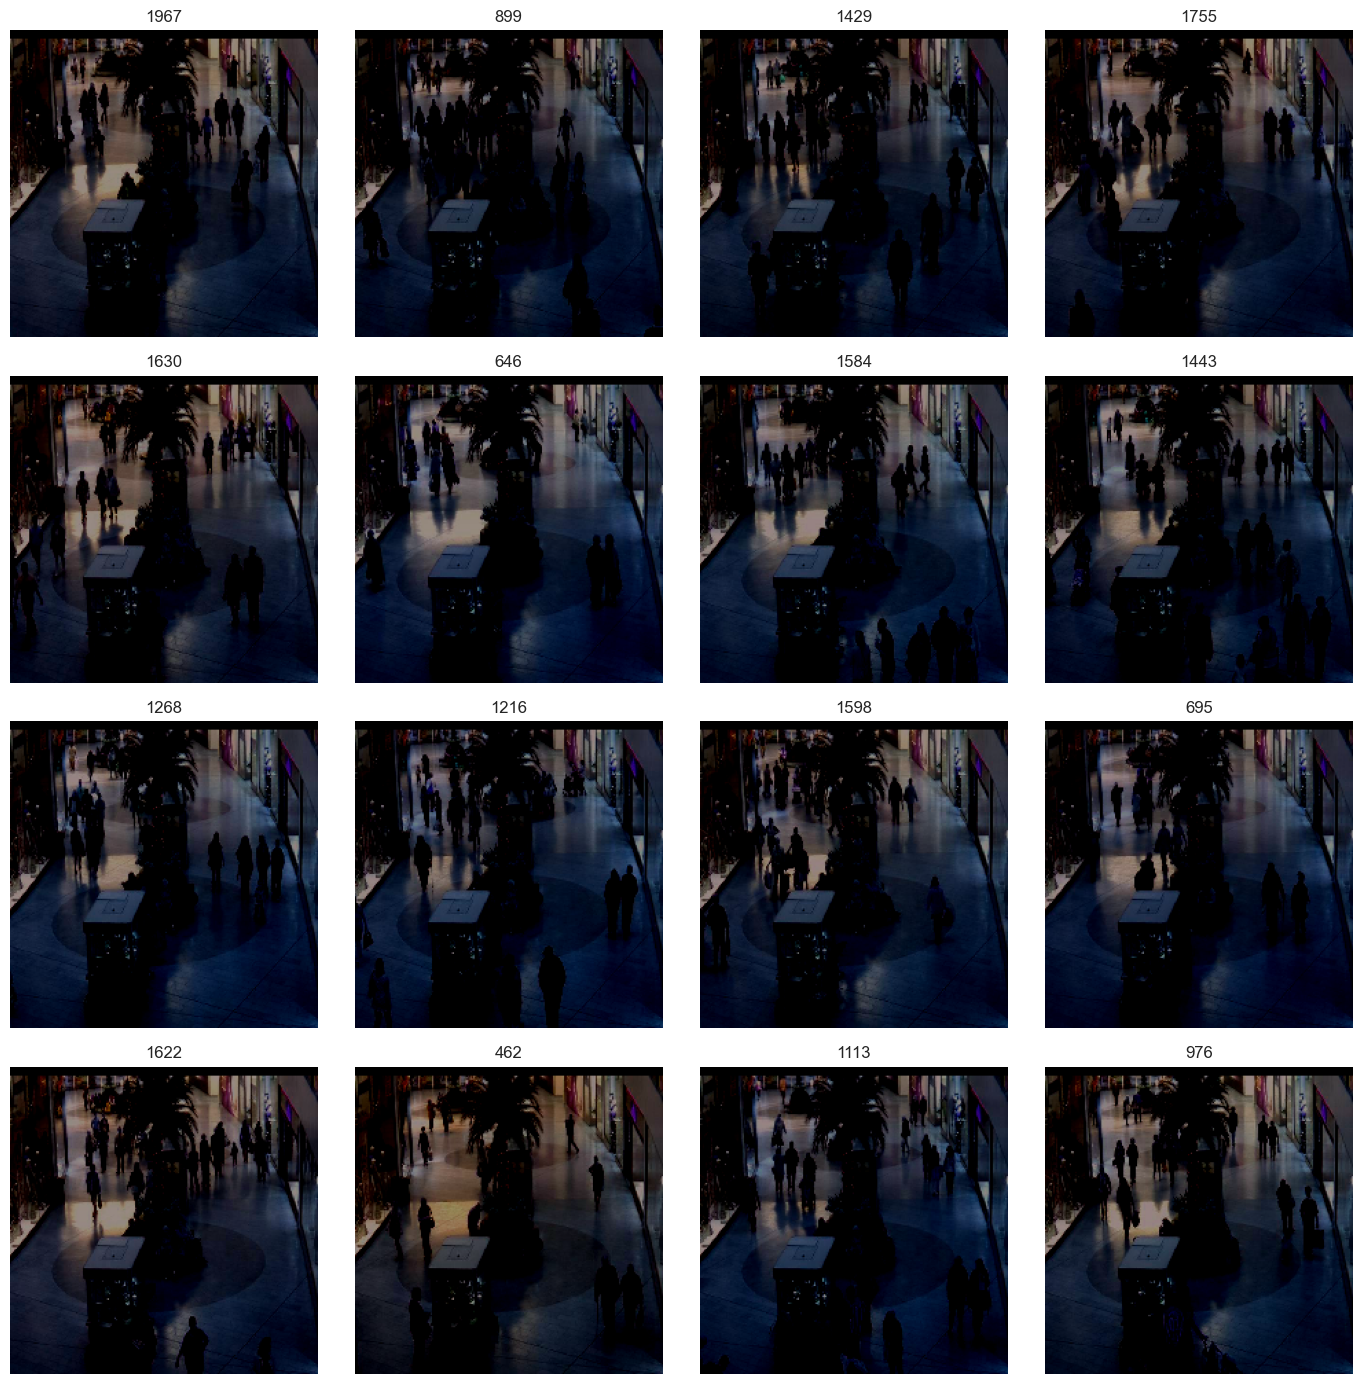

In [28]:
import numpy as np
import matplotlib.pyplot as plt
# Örnek bir image değişkeni tanımlama
image = plt.imread(r"C:\Users\bakiD\OneDrive\Belgeler\Yeni klasör (7)\frames\seq_000033.jpg")  # Görüntü dosyasının yolunu doğru bir şekilde belirtmelisiniz

clipped_image = np.clip(image, 0, 255)

# Bir sonraki toplu veriyi al
batch = next(train_generator)

# 4x4'lük bir alt grafik düzeni oluşturun
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()

# Veri toplu boyutunu ve alt grafik sayısını minimuma alarak döngü yapın
for i in range(min(len(axes), len(batch[0]))):
    ax = axes[i]
    ax.imshow(batch[0][i])  # Görüntüyü göster
    ax.axis('off')  # Eksenleri kapat
    ax.set_title(batch[1][i])  # Başlık belirle

    clipped_image = np.clip(batch[0][i], 0, 1)  # Görüntüyü [0, 1] aralığına sığdır
    ax.imshow(clipped_image)


# Grafikleri düzgün bir şekilde yerleştirin
plt.tight_layout()

# Grafikleri göster
plt.show()



In [29]:


base_model = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)



In [14]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:


k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True



Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 3,153,921 (12.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [18]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [19]:


# Compile the model
model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)



In [20]:


# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)



In [21]:
history = model.fit(
    train_generator,
    epochs=80,
    validation_data=valid_generator,
    verbose=2,
    callbacks=[learning_rate_reduction]
)


Epoch 1/80


C:\Users\bakiD\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 - 94s - 4s/step - loss: 1359188.6250 - mean_absolute_error: 1065.0629 - mean_squared_error: 1359188.6250 - val_loss: 16476.6445 - val_mean_absolute_error: 108.6837 - val_mean_squared_error: 16618.4551 - learning_rate: 0.0010
Epoch 2/80
25/25 - 84s - 3s/step - loss: 485609.9062 - mean_absolute_error: 571.0676 - mean_squared_error: 485609.9062 - val_loss: 220238.6719 - val_mean_absolute_error: 456.9060 - val_mean_squared_error: 220979.2812 - learning_rate: 0.0010
Epoch 3/80
25/25 - 82s - 3s/step - loss: 198793.0938 - mean_absolute_error: 384.9777 - mean_squared_error: 198793.0938 - val_loss: 1823922.8750 - val_mean_absolute_error: 1353.1997 - val_mean_squared_error: 1841742.2500 - learning_rate: 0.0010
Epoch 4/80

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 - 82s - 3s/step - loss: 190424.9219 - mean_absolute_error: 378.8152 - mean_squared_error: 190424.9219 - val_loss: 1498419.7500 - val_mean_absolute_error: 1218.6434 - val_mean_squared_error:

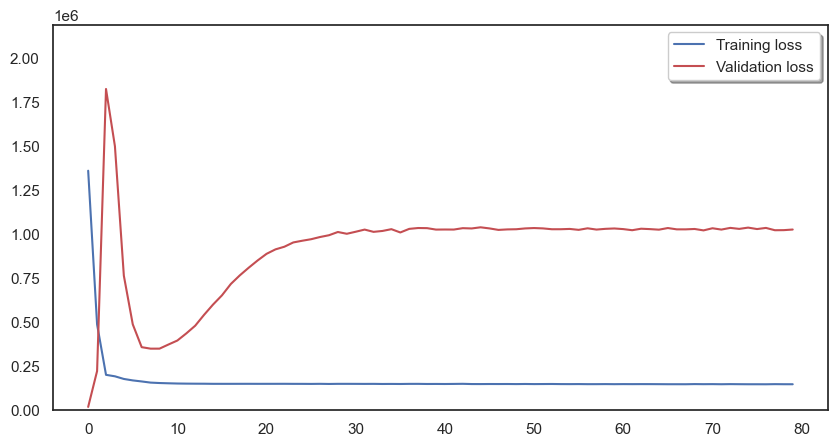

In [22]:


# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss")
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)



In [23]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


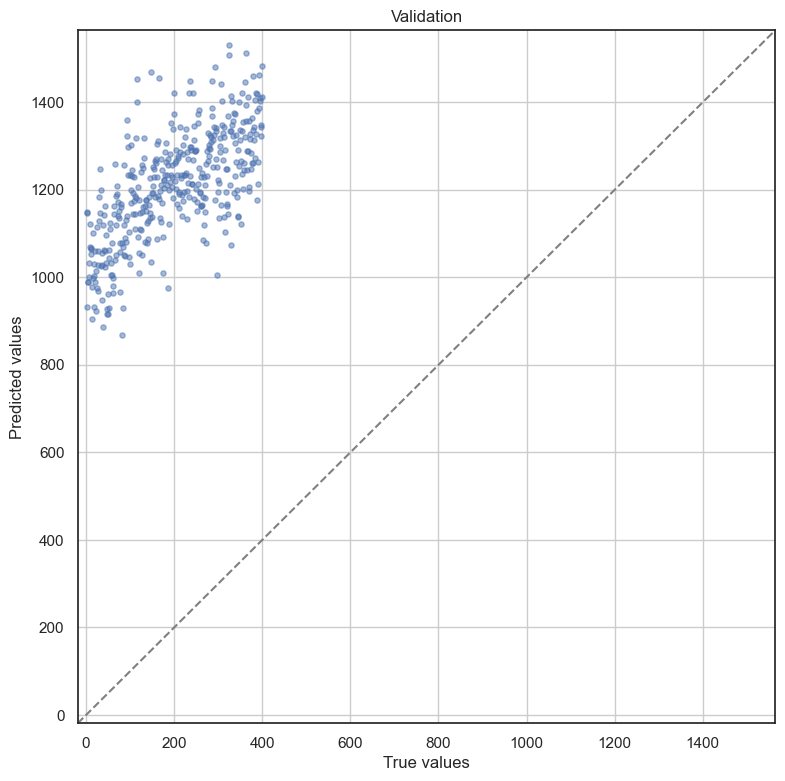

In [24]:


df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()



In [25]:


mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.1f}')



MSE: 1027599.7
Pearson r: 0.7


In [26]:
# Rastgele bir örnek seçin
ornek, etiket = next(train_generator)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


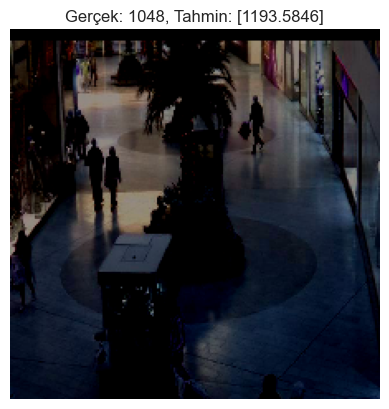

In [27]:
tahmin = model.predict(ornek)

# Görselleştirme
plt.imshow(ornek[0])  # Resmi göster
plt.title(f"Gerçek: {etiket[0]}, Tahmin: {tahmin[0]}")  # Başlık belirle (gerçek etiket ve tahmini göster)
plt.axis('off')  # Eksenleri kapat
plt.show()